In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import isoweek

Les données de l'incidence du syndrome grippal sont disponibles du site Web du [Réseau Sentinelles](http://www.sentiweb.fr/france/fr/). Nous les récupérons sous forme d'un fichier en format CSV dont chaque ligne correspond à une semaine de la période demandée. Nous téléchargeons toujours le jeu de données complet, qui commence en 1991 et se termine avec une semaine récente.

In [2]:
data_url = "http://www.sentiweb.fr/datasets/incidence-PAY-7.csv"

Les données étant mises à jour régulièrement sur le site, on télécharge le fichier de données utilisé puis on utilise la 
copie téléchargée pour faire l'analyse. Cela évite également de re-télécharger les données à chaque fois, ce qui peut
prendre du temps si le fichier est lourd.

In [3]:
data_file = "varicelle.csv"

import os
import urllib.request
if not os.path.exists(data_file):
    urllib.request.urlretrieve(data_url, data_file)

La première ligne du fichier CSV est un commentaire, que nous ignorons en précisant `skiprows=1`.

In [4]:
raw_data = pd.read_csv(data_file, skiprows=1)
raw_data

week  indicator    inc  inc_low  inc_up  inc100  inc100_low  \
0     202022          7    280        0     638       0           0   
1     202021          7    602       36    1168       1           0   
2     202020          7    824       20    1628       1           0   
3     202019          7    310        0     753       0           0   
4     202018          7    849       98    1600       1           0   
5     202017          7    272        0     658       0           0   
6     202016          7    758       78    1438       1           0   
7     202015          7   1918      675    3161       3           1   
8     202014          7   3879     2227    5531       6           3   
9     202013          7   7326     5236    9416      11           8   
10    202012          7   8123     5790   10456      12           8   
11    202011          7  10198     7568   12828      15          11   
12    202010          7   9011     6691   11331      14          10   
13    202009          7  13631    10544   16718      21          16   
14    202008          7  10424     7708   13140      16          12   
15    202007          7   8959     6574   11344      14          10   
16    202006          7   9264     6925   11603      14          10   
17    202005          7   8505     6314   10696      13          10   
18    202004          7   7991     5831   10151      12           9   
19    202003          7   5968     4100    7836       9           6   
20    202002          7   6534     4530    8538      10           7   
21    202001          7   9835     7019   12651      15          11   
22    201952          7   7941     5246   10636      12           8   
23    201951          7   5823     3675    7971       9           6   
24    201950          7   6424     4276    8572      10           7   
25    201949          7   6621     4540    8702      10           7   
26    201948          7   5542     3383    7701       8           5   
27    201947          7   7536     5058   10014      11           7   
28    201946          7   2638     1316    3960       4           2   
29    201945          7   4492     2615    6369       7           4   
...      ...        ...    ...      ...     ...     ...         ...   
1509  199126          7  17608    11304   23912      31          20   
1510  199125          7  16169    10700   21638      28          18   
1511  199124          7  16171    10071   22271      28          17   
1512  199123          7  11947     7671   16223      21          13   
1513  199122          7  15452     9953   20951      27          17   
1514  199121          7  14903     8975   20831      26          16   
1515  199120          7  19053    12742   25364      34          23   
1516  199119          7  16739    11246   22232      29          19   
1517  199118          7  21385    13882   28888      38          25   
1518  199117          7  13462     8877   18047      24          16   
1519  199116          7  14857    10068   19646      26          18   
1520  199115          7  13975     9781   18169      25          18   
1521  199114          7  12265     7684   16846      22          14   
1522  199113          7   9567     6041   13093      17          11   
1523  199112          7  10864     7331   14397      19          13   
1524  199111          7  15574    11184   19964      27          19   
1525  199110          7  16643    11372   21914      29          20   
1526  199109          7  13741     8780   18702      24          15   
1527  199108          7  13289     8813   17765      23          15   
1528  199107          7  12337     8077   16597      22          15   
1529  199106          7  10877     7013   14741      19          12   
1530  199105          7  10442     6544   14340      18          11   
1531  199104          7   7913     4563   11263      14           8   
1532  199103          7  15387    10484   20290      27          18   
1533  199102          7  16277  

Y a-t-il des points manquants dans ce jeu de données ?

In [5]:
raw_data[raw_data.isnull().any(axis=1)]

Empty DataFrame
Columns: [week, indicator, inc, inc_low, inc_up, inc100, inc100_low, inc100_up, geo_insee, geo_name]
Index: []

Aucune donnée n'est manquante, nous gardons donc l'ensemble des lignes pour la suite des analyses.

In [7]:
data = raw_data

Nos données utilisent une convention inhabituelle: le numéro de semaine est collé à l'année, donnant l'impression qu'il s'agit de nombre entier. C'est comme ça que Pandas les interprète.

Un deuxième problème est que Pandas ne comprend pas les numéros de semaine.  Il faut lui fournir les dates de début et de fin de semaine. Nous utilisons pour cela la bibliothèque `isoweek`.

Comme la conversion des semaines est devenu assez complexe, nous écrivons une petite fonction Python pour cela. Ensuite, nous l'appliquons à tous les points de nos donnés. Les résultats vont dans une nouvelle colonne 'period'.

In [8]:
def convert_week(year_and_week_int):
    year_and_week_str = str(year_and_week_int)
    year = int(year_and_week_str[:4])
    week = int(year_and_week_str[4:])
    w = isoweek.Week(year, week)
    return pd.Period(w.day(0), 'W')

data['period'] = [convert_week(yw) for yw in data['week']]

Il restent deux petites modifications à faire.

Premièrement, nous définissons les périodes d'observation comme nouvel index de notre jeux de données. Ceci en fait une suite chronologique, ce qui sera pratique par la suite.

Deuxièmement, nous trions les points par période, dans le sens chronologique.

In [9]:
sorted_data = data.set_index('period').sort_index()

Nous vérifions la cohérence des données. Entre la fin d'une période et le début de la période qui suit, la différence temporelle doit être zéro, ou au moins très faible. Nous laissons une "marge d'erreur" d'une seconde.

In [10]:
periods = sorted_data.index
for p1, p2 in zip(periods[:-1], periods[1:]):
    delta = p2.to_timestamp() - p1.end_time
    if delta > pd.Timedelta('1s'):
        print(p1, p2)

Il ne manque donc aucune période dans nos données.

On réalise un premier affichage des données.

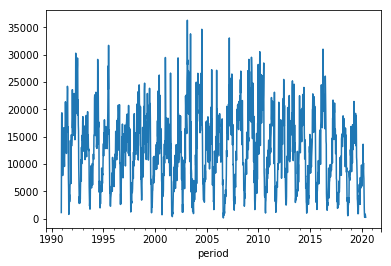

In [11]:
sorted_data['inc'].plot()

Pour que cela soit plus lisible, on zoome sur les dernières années. Cela montre que le pic de l'épidémie a généralement lieu vers mars.

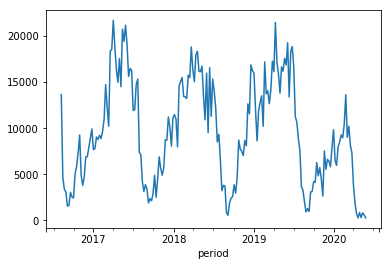

In [12]:
sorted_data['inc'][-200:].plot()

# Etude de l'incidence annuelle

Etant donné que le pic de l'épidémie se situe en mars, à cheval entre deux années civiles, nous définissons la période de référence entre deux minima de l'incidence, du 1er septembre de l'année $N$ au 1er septembre de l'année $N+1$.

Notre tâche est un peu compliquée par le fait que l'année ne comporte pas un nombre entier de semaines. Nous modifions donc un peu nos périodes de référence: à la place du 1er septembre de chaque année, nous utilisons le premier jour de la semaine qui contient le 1er septembre.

Comme l'incidence de la varicelle est très faible en cette période, cette modification ne risque pas de fausser nos conclusions.

Encore un petit détail: les données commencent fin 1991, ce qui rend la première année incomplète. Nous commençons donc l'analyse en 1992.

In [13]:
first_september_week = [pd.Period(pd.Timestamp(y, 9, 1), 'W')
                     for y in range(1992,
                                    sorted_data.index[-1].year)]

En partant de cette liste des semaines qui contiennent un 1er septembre, nous obtenons nos intervalles d'environ un an comme les périodes entre deux semaines adjacentes dans cette liste. Nous calculons les sommes des incidences hebdomadaires pour toutes ces périodes.

Nous vérifions également que ces périodes contiennent entre 51 et 52 semaines, pour nous protéger contre des éventuelles erreurs dans notre code.

In [14]:
year = []
yearly_incidence = []
for week1, week2 in zip(first_september_week[:-1],
                        first_september_week[1:]):
    one_year = sorted_data['inc'][week1:week2-1]
    assert abs(len(one_year)-52) < 2
    yearly_incidence.append(one_year.sum())
    year.append(week2.year)
yearly_incidence = pd.Series(data=yearly_incidence, index=year)

 Voici les incidences annuelles.

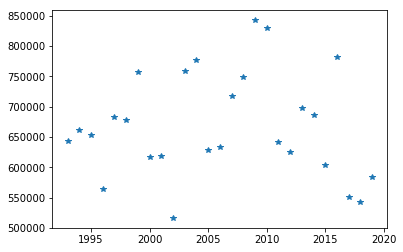

In [15]:
yearly_incidence.plot(style='*')

Une liste triée permet de plus facilement répérer les valeurs les plus faibles (au début) et les plus élevées (à la fin).

In [16]:
yearly_incidence.sort_values()

2002    516689
2018    542312
2017    551041
1996    564901
2019    584066
2015    604382
2000    617597
2001    619041
2012    624573
2005    628464
2006    632833
2011    642368
1993    643387
1995    652478
1994    661409
1998    677775
1997    683434
2014    685769
2013    698332
2007    717352
2008    749478
1999    756456
2003    758363
2004    777388
2016    782114
2010    829911
2009    842373
dtype: int64